# Kaggle Microsoft Malware competition 2019(Currently Active):

# Kindly clone this repo in order to see the interactive data visualization,  done using plotly in the html files, otherwise in jupyter notebooks all the graphs would appear Blank.

### Link : https://www.kaggle.com/c/microsoft-malware-prediction

### Problem Overview: Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. They have provided 82 feature columns, and 8.7 million rows based on which previous detection rates have been measured. The end goal is to come up with a model for predicting malware occurrences in the future.

### Rather than using the entire datset, we have used 1,00,000 randomly sampled rows, from training dataset to keep the session interactive, rather than using the whole dataset.

### Part2: LGBM(Gradient Bossting) Approach For BaseLine Model

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import roc_auc_score
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
#Defining dtypes for large datasets is highly recommended!
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
#Divide the features in numeric and categories
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics] #Will fetch columns, whose dtype is numeric
categorical_columns = [c for c,v in dtypes.items() if v not in numerics] #Will fetch columns , whose dtype is non-numeric

In [4]:
#Reading the dataset
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('datasets/train.csv',                    
                    usecols = retained_columns,
                    dtype = dtypes)


In [5]:
train.shape

(100000, 83)

In [ ]:
#Thus here we are having 100k rows and 83 columns.

In [6]:
train.head(3)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,844d853facbcb13bfa199cd1c324e7d7,mse,1.1.15200.1,4.10.209.0,1.275.1141.0,0,7.0,0,NaN,29199.0,1.0,1.0,0,160,48464.0,NaN,204.0,-86,windows7,x64,6.1.1.0,7601,256,windows7,7601.24231.amd64fre.win7sp1_ldr.180810-0600,Pro,1.0,0,NaN,0.0,337.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,260852.0,4.0,5.0,2514.0,NaN,476940.0,HDD,459894.0,0,4096.0,Laptop,13.203125,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.192,amd64,rs3_release,16299,192,Core,CORE,Update,25.0,115,FullAuto,0,OFFLINE,Retail,NaN,0.0,Retail,NaN,355.0,20951.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
1,c288dc9fe2d0075c3ba6acce68ac9c8e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.941.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,85783.0,18.0,53.0,42,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,35266.0,4.0,5.0,2572.0,NaN,953869.0,HDD,99331.0,0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,Clean,37.0,158,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,19289.0,1,NaN,0.0,0,0,0.0,1.0,7.0,1
2,310d4bcd870e3f33cb4ee48b0b22a58c,win8defender,1.1.15200.1,4.18.1807.18075,1.275.112.0,0,7.0,0,NaN,44914.0,2.0,1.0,1,35,107225.0,27.0,45.0,60,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,Warn,1.0,1.0,Desktop,Windows.Desktop,2206.0,343356.0,4.0,5.0,2304.0,NaN,953869.0,HDD,931762.0,0,6144.0,Desktop,24.093750,1920.0,1200.0,Desktop,NaN,4.294967e+09,10.0.17134.112,amd64,rs4_release,17134,112,Core,CORE,UUPUpgrade,8.0,31,Notify,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,93.0,17553.0,1,0.0,0.0,0,0,0.0,0.0,4.0,1


In [7]:
y = train['HasDetections']

In [8]:
train.drop('HasDetections', axis=1, inplace=True)

In [9]:
train.shape

(100000, 82)

In [ ]:
#Checking the missing Values %age, and number of unqiue values for every column

In [10]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,1,99.969,99.969,category
41,Census_ProcessorClass,3,99.579,99.579,category
8,DefaultBrowsersIdentifier,252,95.123,95.123,float16
68,Census_IsFlightingInternal,1,82.965,82.965,float16
52,Census_InternalBatteryType,20,70.975,70.975,category
71,Census_ThresholdOptIn,2,63.393,63.393,float16
75,Census_IsWIMBootEnabled,1,63.303,63.303,float16
31,SmartScreen,11,35.363,48.678,category
15,OrganizationIdentifier,40,30.957,46.845,float16
29,SMode,2,6.034,93.924,float16


In [ ]:
#Lets remove the bad/unbalanced columns!

# There are 26 columns in total in which one category contains 90% values. I think that these imbalanced columns should be removed from the dataset

In [11]:
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    #Will find out if the biggest category has 90% of values!
    if rate > 0.9:
        good_cols.remove(col)

In [12]:
len(good_cols)

56

In [ ]:
#Thus we ended up removing 26 columns, from 83

In [11]:
#Making the same test set, that we used in our previous RandomForestApproach!

In [13]:
train = train[good_cols]

In [14]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000  # 20% of total data
n_trn = len(train)-n_valid
raw_train, raw_valid = split_vals(train, n_trn)
X_train, X_valid = split_vals(train, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((80000, 56), (80000,), (20000, 56), (20000,))

In [15]:
test = pd.concat([X_valid, y_valid],axis=1)

In [16]:
train = pd.concat([X_train, y_train],axis=1)

In [19]:
test.head(2)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
80000,c1182c2f2d4cc09095d608a448a3675a,1.1.15200.1,4.13.17134.1,1.275.852.0,53447.0,1.0,141,147039.0,27.0,167.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,NaN,Notebook,1443.0,256480.0,4.0,5.0,2382.0,953869.0,HDD,940826.0,4096.0,Laptop,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.1,rs4_release,17134,1,Core,CORE,Other,8.0,31,UNKNOWN,IS_GENUINE,OEM:DM,NaN,NaN,355.0,9358.0,1,NaN,0,0.0,10.0,1
80001,f66db2f196ccfe9b019aefc7bf3c0d09,1.1.15100.1,4.18.1807.18075,1.273.1523.0,53447.0,1.0,155,82373.0,18.0,277.0,75,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,NaN,NaN,4.0,5.0,2304.0,476940.0,HDD,275566.0,4096.0,Desktop,20.0,1600.0,900.0,Workstation,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,8.0,31,FullAuto,IS_GENUINE,Retail,NaN,NaN,559.0,24754.0,0,NaN,0,1.0,10.0,1


In [20]:
train.head(2)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,844d853facbcb13bfa199cd1c324e7d7,1.1.15200.1,4.10.209.0,1.275.1141.0,29199.0,1.0,160,48464.0,NaN,204.0,-86,7601,256,windows7,7601.24231.amd64fre.win7sp1_ldr.180810-0600,Pro,337.0,NaN,Notebook,1443.0,260852.0,4.0,5.0,2514.0,476940.0,HDD,459894.0,4096.0,Laptop,13.203125,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.192,rs3_release,16299,192,Core,CORE,Update,25.0,115,FullAuto,OFFLINE,Retail,NaN,NaN,355.0,20951.0,0,NaN,0,0.0,3.0,0
1,c288dc9fe2d0075c3ba6acce68ac9c8e,1.1.15200.1,4.18.1807.18075,1.275.941.0,53447.0,1.0,43,85783.0,18.0,53.0,42,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,NaN,Notebook,2668.0,35266.0,4.0,5.0,2572.0,953869.0,HDD,99331.0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,0.0,10.0.17134.228,rs4_release,17134,228,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,Clean,37.0,158,FullAuto,IS_GENUINE,Retail,NaN,NaN,628.0,19289.0,1,NaN,0,1.0,7.0,1


In [21]:
train.shape,test.shape

((80000, 57), (20000, 57))

In [ ]:
#Dividing the types of variables in  2 categories!

In [17]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]
len(binary_variables)

5

In [18]:
#The remaining will surely be cat columns
categorical_columns = [c for c in train.columns 
                       if  (c not in binary_variables)]
len(categorical_columns)

52

In [19]:
#Using plotly pie chart!
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

In [ ]:
#Dealing with categories, lets check the cardinality that is number of unique values in a cat column!

In [20]:
cardinality = []

In [21]:
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    #Since, we dont need to count the unique id
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)     #Sorting the values in desired manner

In [22]:
trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [26]:
#Time for some EDA analysis!

In [23]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [ ]:
#Make your own plotting functions, for convenience purpose can be used for mostly every column! 

In [24]:
def plot_cat(col,bars_only=False,top_n=10):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    #This means if the unique entries in a column is greater than 10, keep their value as 10 otherwise, if its smaller than 10
    #than use that specific value less than 10! e.g in case of hasDetection it will be 2
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())
    if not bars_only:
        df = train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
    #Will return a df, with 2 columns, 1 count of that specific category ,2) Mean value for detection rate 
        df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
    #Use to keep index order in check
        data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]
        #Bars containing combined total of has_detection & noDetection, whereas scatter represent mean of target value

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))
        
    else:
            top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
            #This will fetch the index for that unique entries
            df0 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
                    #Make sure that column index present & fetch entries when has_Detect==1,  column_We_inspecting
            df1 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
                    #Same for the case now, when no detection is found!
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
    py.iplot(dict(data=data, layout=layout))
            
            
    

In [25]:
plot_cat('HasDetections',True)


HasDetections has 2 unique values and type: int8.
0    0.503487
1    0.496513
Name: HasDetections, dtype: float64


### Here checking the degree of spread, of target variabel! Seems Evenly Distributed!

In [31]:
#Experimenting with a few important features, that were found after using feature importance below!

In [26]:
plot_cat('CountryIdentifier',True)

CountryIdentifier has 221 unique values and type: int16.
43     0.044213
29     0.038525
141    0.038062
93     0.031575
171    0.031062
Name: CountryIdentifier, dtype: float64


### Here we have a categorical column which was defined as numerical.While most countries have rate of detections ~50%, there are some countries where there are much more infected devices.

In [27]:
plot_cat('Census_OSVersion',True)

Census_OSVersion has 254 unique values and type: category.
10.0.17134.228    0.158587
10.0.17134.165    0.102888
10.0.16299.431    0.062762
10.0.17134.285    0.051862
10.0.16299.547    0.038187
Name: Census_OSVersion, dtype: float64


In [34]:
plot_cat('AvSigVersion')

AvSigVersion has 3717 unique values and type: category.
1.273.1420.0    0.011038
1.275.1140.0    0.010950
1.263.48.0      0.010875
1.275.727.0     0.009962
1.273.1826.0    0.009763
Name: AvSigVersion, dtype: float64


### This feature has a huge amount of categories, it seems this is a version of an often updated software.

In [35]:
plot_cat('AVProductsInstalled', True)

AVProductsInstalled has 5 unique values and type: float16.
 1.0    0.693550
 2.0    0.278300
 3.0    0.023325
NaN     0.003950
 4.0    0.000862
Name: AVProductsInstalled, dtype: float64


### Intersting Insight here, by increasing the number of Anti-Virus Products,detection rate rather decreases, instead of increasing.

In [36]:
plot_cat('AVProductStatesIdentifier',True)

AVProductStatesIdentifier has 1820 unique values and type: float32.
53447.0    0.650775
7945.0     0.055200
47238.0    0.036388
62773.0    0.029538
46413.0    0.012500
Name: AVProductStatesIdentifier, dtype: float64


### This one again looks like a categorical variable

In [37]:
plot_cat('AppVersion')

AppVersion has 76 unique values and type: category.
4.18.1807.18075    0.575762
4.18.1806.18062    0.094437
4.12.16299.15      0.039563
4.10.209.0         0.031162
4.13.17134.1       0.029462
Name: AppVersion, dtype: float64


In [ ]:
#Time for categorical variable encoding!

In [28]:
#Top variables with most cardinality(high number of unique values, 1000+) we will frequency encode those variables
frequency_encoded_variables = [
    'Census_SystemVolumeTotalCapacity',
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'AVProductStatesIdentifier',
    'Census_ProcessorModelIdentifier'
]

In [29]:
#Using frequency/Target  Encoding, learnt this technique from a kaggle kernel
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [30]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


In [ ]:
#Label Encoding, the rest of categorical columns

In [31]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])

100%|██████████| 45/45 [00:01<00:00, 38.89it/s]


In [ ]:
#Encoding done!

In [42]:
test[:2]

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
80000,c1182c2f2d4cc09095d608a448a3675a,0,7,60.0,0.0,0,25,197.0,1,22,5,1,1,1,1,1,1,-1,0,0,11.0,0,0,4.0,1,0,10275.0,0,0,1,0,0,0,-1,0,31,1,1,14,0,0,6,2,2,2,1,1,-1,NaN,0,310.0,1,-1,0,0.0,4,1
80001,f66db2f196ccfe9b019aefc7bf3c0d09,1,1,202.0,0.0,0,19,1.0,0,16,5,1,0,1,1,0,1,3,1,-1,NaN,0,0,78.0,0,0,10275.0,0,2,45,5,5,3,-1,1,1,1,1,1,3,3,2,2,2,0,1,0,-1,NaN,24,2590.0,0,-1,0,1.0,4,1


In [44]:
#Forming Train&Test datasets!

In [32]:
badcols = ['HasDetections','MachineIdentifier','Census_InternalPrimaryDiagonalDisplaySizeInInches','LocaleEnglishNameIdentifier','Census_InternalBatteryNumberOfCharges']

In [48]:
categorical_columns = [col for col in categorical_columns if col not in ['MachineIdentifier','Census_InternalPrimaryDiagonalDisplaySizeInInches','LocaleEnglishNameIdentifier','Census_InternalBatteryNumberOfCharges']]

In [33]:
train.shape

(80000, 57)

In [40]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,844d853facbcb13bfa199cd1c324e7d7,0,0,187.0,8.0,0,0,6647.0,-1,0,0,0,0,0,0,0,0,-1,0,0,474.0,0,0,61.0,0,0,3259.0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,NaN,0,578.0,0,-1,0,0.0,0,0
1,c288dc9fe2d0075c3ba6acce68ac9c8e,0,1,49.0,0.0,0,1,1095.0,0,1,1,1,1,1,1,1,1,-1,0,1,189.0,0,0,116.0,1,0,9515.0,1,1,1,1,1,0,-1,0,1,1,1,1,1,1,1,1,1,0,1,0,-1,NaN,1,846.0,1,-1,0,1.0,1,1
2,310d4bcd870e3f33cb4ee48b0b22a58c,0,1,33.0,97.0,1,2,270.0,1,2,2,1,1,1,1,1,1,0,1,2,6816.0,0,0,78.0,1,0,10275.0,2,2,2,1,2,1,-1,1,2,1,1,2,0,0,2,2,2,1,1,0,0,0.0,2,600.0,1,0,0,0.0,2,1
3,7285553d1cf62469ae953b1cf73d2419,1,1,333.0,NaN,-1,3,19.0,-1,3,3,2,1,2,2,1,2,1,0,1,48.0,0,0,157.0,0,0,182.0,3,3,3,0,0,0,0,0,3,2,0,3,2,2,3,2,2,1,1,1,-1,0.0,1,186.0,1,0,0,1.0,3,0
4,1d2b5c5a18fb6bf670a2f2a851502cf5,0,1,643.0,0.0,0,4,6303.0,-1,4,4,1,1,1,1,1,1,-1,0,1,127.0,0,0,23.0,1,0,10275.0,0,1,1,0,0,0,-1,0,1,1,1,1,2,2,4,3,3,0,1,1,-1,NaN,1,514.0,0,-1,0,0.0,0,1


In [24]:
target = train['HasDetections']


In [44]:
train = train.drop(badcols,axis=1)
test = test.drop(badcols,axis=1)
train.shape,test.shape

((80000, 52), (20000, 52))

In [ ]:
#Time to train the LGBM Model

In [70]:
#Hyper-param tuning
    params = {'num_leaves': 30,
         'min_data_in_leaf': 70, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.3,
         "bagging_fraction": 0.3,
         "metric": 'auc',
         "random_state": 42,
         "verbosity": -1}

In [79]:
#Now performing k-fold 5 splits!
folds = KFold(n_splits=5, shuffle=True, random_state=42)
categorical_columns = [x for x in categorical_columns if x not in badcols] #to hold cat. columns
features = [c for c in train.columns] #features
predictions = np.zeros(len(test))
score = [0 for _ in range(folds.n_splits)] #5 scores for 5 diff rmse!
roc_l = []
roc_mean = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    X_train = train.iloc[trn_idx][features]
    X_valid = train.iloc[val_idx][features]
    y_train = target.iloc[trn_idx]
    y_valid = target.iloc[val_idx]
     #to hold predictions
    #remove this for final
    
    
    
    trn_data = lgb.Dataset(X_train,
                           label=y_train,
                           categorical_feature = categorical_columns,

                          )
    val_data = lgb.Dataset(X_valid,
                           label=y_valid,
                           reference=trn_data,
                           categorical_feature = categorical_columns,

                          )

    num_round = 10000
    model = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                   )
    #To fine tune the model
    pred_test_y = model.predict(X_valid, num_iteration=model.best_iteration)
    #For final predictions
    pred_test = model.predict(test, num_iteration=model.best_iteration)
    predictions += pred_test/5
    
    
    #Printing the mean of rmse after, 5 fold validation
    roc = roc_auc_score(y_valid, pred_test_y)
    roc_l.append(roc)
    
roc_array = np.asarray(roc_l)
    
roc_mean.append(roc_array.mean())

print('Mean roc value: '+str(roc_mean[0]))

    
    


fold n°0


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.75517	valid_1's auc: 0.694316
[1000]	training's auc: 0.784323	valid_1's auc: 0.697284
[1500]	training's auc: 0.805002	valid_1's auc: 0.697853
Early stopping, best iteration is:
[1485]	training's auc: 0.804469	valid_1's auc: 0.697875
fold n°1


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.754798	valid_1's auc: 0.699432
[1000]	training's auc: 0.784033	valid_1's auc: 0.701762
Early stopping, best iteration is:
[1092]	training's auc: 0.788113	valid_1's auc: 0.702031
fold n°2


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.756217	valid_1's auc: 0.693949
[1000]	training's auc: 0.785586	valid_1's auc: 0.694719
Early stopping, best iteration is:
[1004]	training's auc: 0.785731	valid_1's auc: 0.694759
fold n°3


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.754073	valid_1's auc: 0.700419
[1000]	training's auc: 0.783291	valid_1's auc: 0.703404
Early stopping, best iteration is:
[1096]	training's auc: 0.787396	valid_1's auc: 0.703718
fold n°4


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.755006	valid_1's auc: 0.699132
[1000]	training's auc: 0.784475	valid_1's auc: 0.700532
Early stopping, best iteration is:
[1092]	training's auc: 0.788665	valid_1's auc: 0.700626
Mean roc value: 0.6998019317724725



### Just using some simple common sense, we removed 3 columns that were high on list of feature importance but was holding the model down, these 3 columns were:
### 1) Census_InternalPrimaryDiagonalDisplaySizeInInches(Not possible for malware to be dependent upon this variable, since how can malware be dependent upon your screen size).
### 2)LocaleEnglishNameIdentifier (Irrelevant to malware prediction)
### 3)Census_InternalBatteryNumberOfCharges (Irrelevant to malware prediction)
### --->Performance increased from 69.3%- 70%(0.7% increase) after removing these 3 columns that were in top10 of feature importance earlier

In [ ]:
badcols = ['Census_InternalPrimaryDiagonalDisplaySizeInInches','LocaleEnglishNameIdentifier','Census_InternalBatteryNumberOfCharges']

### Feature Importance

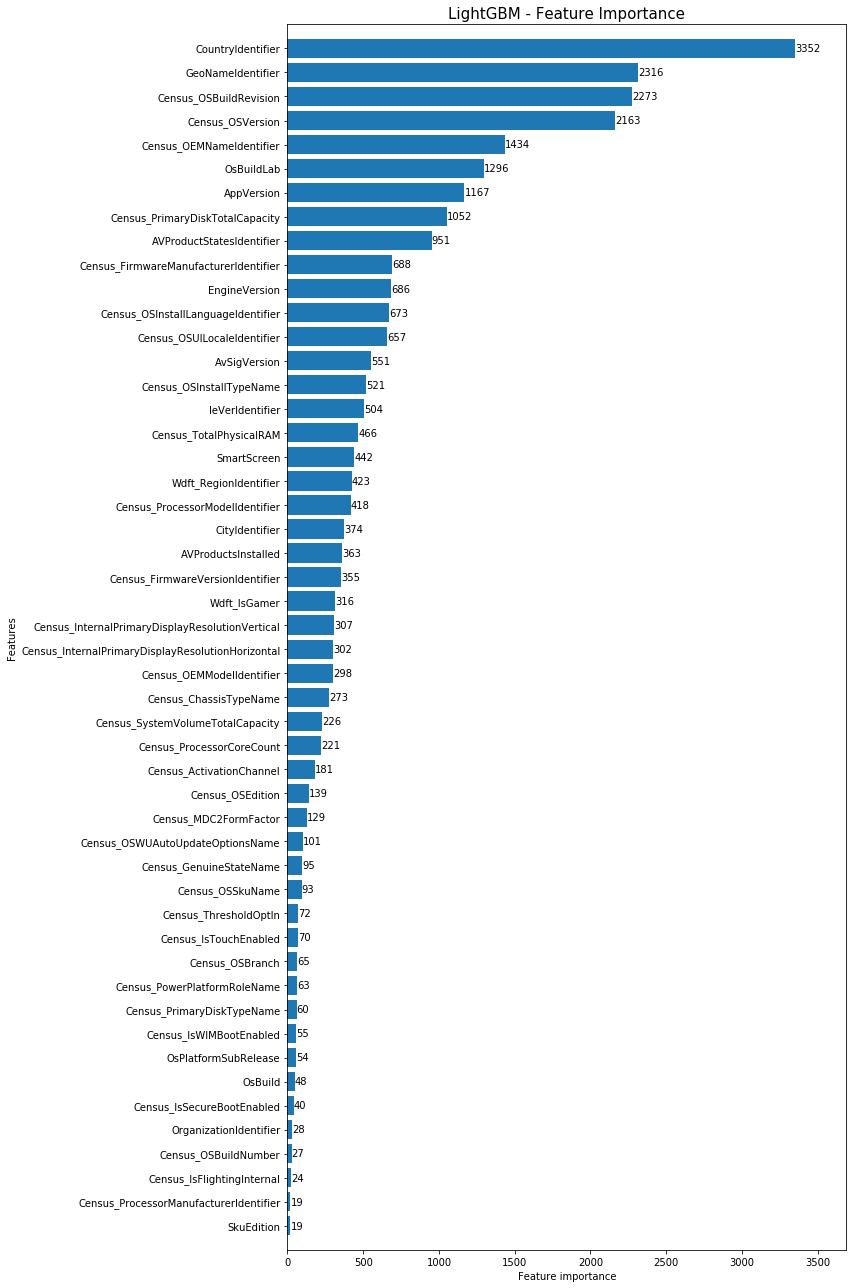

In [52]:

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.tight_layout()
plt.savefig('lgbm_1st4mil_importances.png')
plt.show()




# To conclude this project here, we observed an improvement from :
## 53% validation auc accuracy on using  RandomForest with default parameters -> 63 % of acc. on fine tuned RandomForest   auc accuracy --> 70% after Frequency-Encoding Categorical Variables with high cardinality  & using LightGradientBoostingModel.
## Tested on the sample of 1,00,000 randomized rows from 8.7 million given rows.
## On using same model for complete dataset in my kaggle submission, achieved accuracy of 61% using Rf on provided test set by kaggle, and 67.7% after using  grid search with LGBM  on test set provided by kaggle.
## Currenlty ranked in Top 500 of the competition.


# In order to improve the model following things that can be considered:
## 1) Feature Engineering
## 2) Using sparse matrix concept to load complete dataset
## 3) Ensembele Learning
